Binary Bank Competition - Kaggle


### Jupyter Notebook in VS Code

From directory with virtual environment, use terminal command to use Jupyter Notebook in VS Code:

jupyter notebook --NotebookApp.allow_origin='*' --NotebookApp.ip='0.0.0.0'

### Run TensorBoard

From directory with virtual environment:

tensorboard --logdir binary_bank_comp/runs

### Select Python Interpreter

Open Command Palette as follows: Ctrl+Shift+P

Then select from VS Code Command Palette: "Python: Select Interpreter" and choose the same Python interpreter that you used to install Jupyter.

If server not shown, enter server manually as follows: 
http://localhost:8888

Reminder:  pw: ""

In [82]:
from datetime import datetime

import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from stepbystep_v0 import StepByStep

# Binary Classification Problem based on Bank Customer Marketing Call Data

# Model Training

### Load Training Data

In [60]:
# Import data from .csv files
raw_train_data = pd.read_csv('binary_bank_comp/dataset/train.csv')

# Display the first few rows of the dataset
print(raw_train_data[:5])

   id  age          job  marital  education default  balance housing loan  \
0   0   42   technician  married  secondary      no        7      no   no   
1   1   38  blue-collar  married  secondary      no      514      no   no   
2   2   36  blue-collar  married  secondary      no      602     yes   no   
3   3   27      student   single  secondary      no       34     yes   no   
4   4   26   technician  married  secondary      no      889     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  y  
0  cellular   25   aug       117         3     -1         0  unknown  0  
1   unknown   18   jun       185         1     -1         0  unknown  0  
2   unknown   14   may       111         2     -1         0  unknown  0  
3   unknown   28   may        10         2     -1         0  unknown  0  
4  cellular    3   feb       902         1     -1         0  unknown  1  


### Split the train dataset

In [61]:
# Remove id column
raw_train_data.drop(columns=['id'], inplace=True)

# Split the dataset into features and target variable
X = raw_train_data.drop(columns=['y'])
y = raw_train_data['y']

# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

# Print the first few rows of the training set
print("Training set preview:")
print(X_train.head())
print(y_train.head())

Training set shape: (600000, 16) (600000,)
Validation set shape: (150000, 16) (150000,)
Training set preview:
        age          job   marital  education default  balance housing loan  \
453635   28  blue-collar    single  secondary      no     5090     yes  yes   
11651    51   technician   married   tertiary      no     1295      no   no   
431999   57   management  divorced   tertiary      no        0      no   no   
529211   48  blue-collar    single    primary      no     1323     yes   no   
110925   38       admin.   married  secondary      no      659     yes   no   

         contact  day month  duration  campaign  pdays  previous poutcome  
453635   unknown   12   may      1297         2     -1         0  unknown  
11651   cellular   27   aug       119         9     -1         0  unknown  
431999  cellular   29   jan        87         1     -1         0  unknown  
529211   unknown   15   may        83         5     -1         0  unknown  
110925  cellular   28   jul       5

### Data Cleaning

In [62]:
# Clean the dataset

# Identify numerical columns (excluding the target and any non-feature columns)
X_train_numerical_cols = X_train.select_dtypes(include=['int64', 'float64'])
X_val_numerical_cols = X_val.select_dtypes(include=['int64', 'float64'])

# Identify categorical columns
X_train_categorical_cols = X_train.select_dtypes(include=['object', 'category'])
X_val_categorical_cols = X_val.select_dtypes(include=['object', 'category'])

# Convert categorical features to numerical using one-hot encoding using 1s and 0s
X_train_categorical_encoded = pd.get_dummies(X_train_categorical_cols, drop_first=False).astype(int)
X_val_categorical_encoded = pd.get_dummies(X_val_categorical_cols, drop_first=False).astype(int)

# Combine the numerical and categorical features
X_train_combined = pd.concat([X_train_numerical_cols, X_train_categorical_encoded], axis=1)
X_val_combined = pd.concat([X_val_numerical_cols, X_val_categorical_encoded], axis=1)

# Numeric Feature Standardization
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_combined)
X_val_scaled = sc.transform(X_val_combined)

# Convert the scaled arrays back to DataFrames for easier handling
X_train = pd.DataFrame(X_train_scaled, columns=X_train_combined.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X_val_combined.columns)

# Show the cleaned dataset
print(X_train)
print(X_val)

             age   balance       day  duration  campaign     pdays  previous  \
0      -1.278540  1.365772 -0.499343  3.820120 -0.211544 -0.302805 -0.222073   
1       0.999811  0.031782  1.318267 -0.503479  2.365296 -0.302805 -0.222073   
2       1.594163 -0.423427  1.560615 -0.620928 -0.579664 -0.302805 -0.222073   
3       0.702634  0.041624 -0.135821 -0.635610  0.892816 -0.302805 -0.222073   
4      -0.287953 -0.191780  1.439441  1.019690  0.524696 -0.302805 -0.222073   
...          ...       ...       ...       ...       ...       ...       ...   
599995 -0.981364 -0.220604  1.439441 -0.492468  0.524696  2.050922  1.266816   
599996 -0.981364 -0.423427  1.439441 -0.617258  0.156576 -0.302805 -0.222073   
599997 -1.080423  0.004716  0.954745 -0.764070 -0.579664 -0.302805 -0.222073   
599998  0.306400 -0.257161  1.802963 -0.657631 -0.211544 -0.302805 -0.222073   
599999  1.396045 -0.423427 -1.347561 -0.598907 -0.579664 -0.302805 -0.222073   

        job_admin.  job_blue-collar  jo

### Data Preparation

In [63]:
torch.manual_seed(13)

# Convert pandas DataFrames to Numpy arrays
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
x_val_tensor = torch.as_tensor(X_val).float()
# Reshapes y_train and y_val to be column vectors
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
batch_size = 500
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

## Model
$$
\Large
y = b + w_1x_1 + w_2x_2 + ... + w_nx_n + \epsilon
$$
$$
\Large 
y =
\begin{cases}
1,\ \text{if }b + w_1x_1 + w_2x_2 + ... + w_nx_n \ge 0
\\
0,\ \text{if }b + w_1x_1 + w_2x_2 + ... + w_nx_n < 0
\end{cases}
$$
### Logits
$$
\Large
z = b + w_1x_1 + w_2x_2 + ... + w_nx_n
$$
### Probabilities
$$
\Large
\begin{aligned}
& \text{P}(y=1) \approx 1.0, & \text{if } &z \gg 0
\\
& \text{P}(y=1) = 0.5, & \text{if } &z = 0
\\
& \text{P}(y=1) \approx 0.0, & \text{if } &z \ll 0
\end{aligned}
$$
### From Logits to Probabilities
$$
\Large
\begin{aligned}
b + w_1x_1 + w_2x_2 + ... + w_nx_n = &\ z = \text{log}\left(\frac{p}{1-p}\right) \nonumber
\\
e^{b + w_1x_1 + w_2x_2 + ... + w_nx_n} = &\ e^z = \frac{p}{1-p} \nonumber
\end{aligned}
$$
$$
\Large
\begin{aligned}
\frac{1}{e^z}& = \frac{1-p}{p}
\\
e^{-z}& = \frac{1}{p} - 1
\\
1 + e^{-z}& = \frac{1}{p}&
\\
p& = \frac{1}{1 + e^{-z}}
\end{aligned}
$$
$$
\Large
p = \sigma(z) = \frac{1}{1+e^{-z}}
$$
### Logistic Regression
$$
\Large
\text{P}(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2 + ... + w_nx_n) = \frac{1}{1+e^{-(b+w_1x_1+w_2x_2 + ... + w_nx_n)}}      
$$
### A Note on Notation (for reference)
$$
\Large W =
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X = 
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
$$
$$
\Large 
\begin{aligned}
z
& = W^T X
=
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= \underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}\\
& = b + w_1x_1 + w_2x_2
\end{aligned}
$$
## Loss
$$
\Large y_i = 1 \Rightarrow \text{error}_i=\text{log}(\text{P}(y_i=1))
$$
$$
\Large \text{P}(y_i=0)=1-\text{P}(y_i=1)
$$
$$
\Large y_i = 0 \Rightarrow \text{error}_i=\text{log}(1-\text{P}(y_i=1))
$$
$$
\Large
\text{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
$$
$$
\Large
\text{BCE}(y)={-\frac{1}{N}\sum_{i=1}^{N}{\left[y_i \text{log}(\text{P}(y_i=1)) + (1-y_i) \text{log}(1-\text{P}(y_i=1))\right]}}
$$

### Model Configuration

In [64]:
# Sets learning rate - "eta" ~ the "n" like Greek letter
lr = 0.001

torch.manual_seed(42)
feature_cnt = X_train.shape[1]
print("Number of features:", feature_cnt)
model = nn.Sequential()
# model.add_module('dropout0', nn.Dropout(0.20))
model.add_module('linear0', nn.Linear(feature_cnt, 200))
model.add_module('activation0', nn.LeakyReLU())
model.add_module('dropout1', nn.Dropout(0.45))
model.add_module('linear1', nn.Linear(200, 60))
model.add_module('activation1', nn.LeakyReLU())
model.add_module('dropout2', nn.Dropout(0.25))
# model.add_module('linear2', nn.Linear(40, 8))
# model.add_module('activation2', nn.LeakyReLU())
model.add_module('output', nn.Linear(60, 1))

# Defines a SGD optimizer to update the parameters
# optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines an Adam optimizer to update the parameters
# optimizer = optim.Adam(model.parameters(), lr=lr)

# Defines a NAdam optimizer to update the parameters
optimizer = torch.optim.NAdam(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

Number of features: 51


### Model Definition

In [65]:
sbs = StepByStep(model=model, loss_fn=loss_fn, optimizer=optimizer)

### Model Training

In [66]:
n_epochs = 1000

sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('run', folder='binary_bank_comp/runs')
sbs.train(n_epochs)

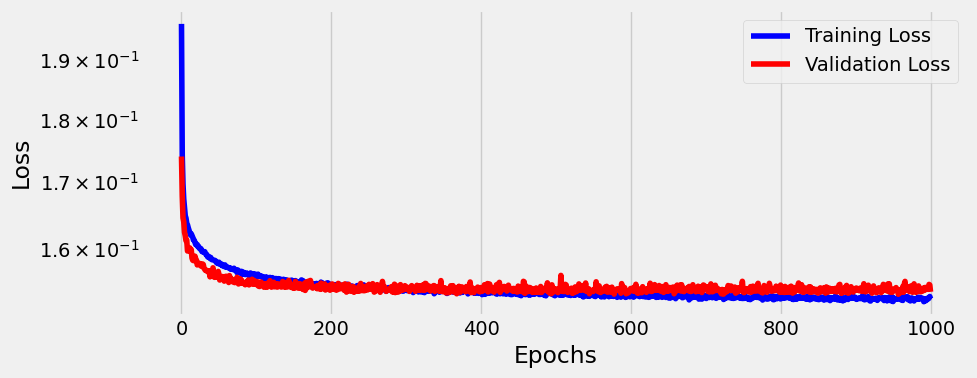

In [67]:
fig = sbs.plot_losses()

In [68]:
print(model.state_dict())

OrderedDict({'linear0.weight': tensor([[ 0.2721,  0.0544, -0.1465,  ...,  0.2507,  0.3812,  0.0363],
        [-2.4299, -0.0176, -0.1023,  ..., -0.2519, -0.2344,  0.7412],
        [-0.1259, -9.5826,  0.0251,  ..., -0.0206, -0.1567,  0.3856],
        ...,
        [ 0.3349,  0.2632,  0.8232,  ..., -0.2935, -0.7357,  2.0400],
        [ 0.3432, -1.4229, -1.1987,  ...,  1.3977,  0.2912,  1.5401],
        [-1.2351, -0.0246,  0.9774,  ...,  0.3519,  0.4013,  0.5268]],
       device='cuda:0'), 'linear0.bias': tensor([-1.0339, -4.9940, -3.2993, -0.9705, -3.8327, -0.0692, -1.6580, -1.1320,
        -1.8404, -3.8166, -2.6923, -3.6066, -4.2149, -5.4480, -0.5380, -3.8012,
        -4.9552, -4.3415, -4.6494, -1.9648, -3.7674, -5.1650, -1.6115, -4.2396,
        -5.9277,  1.2353, -4.0428, -4.3196, -0.9301, -3.8892, -0.5795, -4.0598,
        -2.9678, -0.7617, -3.7868, -3.7165, -1.5721, -4.9053, -2.4545, -4.3011,
        -5.2363, -5.7787, -2.8169, -4.4255, -4.6481, -3.1877, -2.7093, -5.2540,
        -3.004

In [69]:
# Save model
filename='binary_bank_comp/cp3_bth500_lr001_ep1000_dropout45_25.pth'
sbs.save_checkpoint(filename=filename)

## Inference

### Load Test Data

In [73]:
# Import data from .csv file
raw_test_data = pd.read_csv('binary_bank_comp/dataset/test.csv')

# Display the first few rows of the dataset
print(raw_test_data[:5])

       id  age            job  marital  education default  balance housing  \
0  750000   32    blue-collar  married  secondary      no     1397     yes   
1  750001   44     management  married   tertiary      no       23     yes   
2  750002   36  self-employed  married    primary      no       46     yes   
3  750003   58    blue-collar  married  secondary      no    -1380     yes   
4  750004   28     technician   single  secondary      no     1950     yes   

  loan   contact  day month  duration  campaign  pdays  previous poutcome  
0   no   unknown   21   may       224         1     -1         0  unknown  
1   no  cellular    3   apr       586         2     -1         0  unknown  
2  yes  cellular   13   may       111         2     -1         0  unknown  
3  yes   unknown   29   may       125         1     -1         0  unknown  
4   no  cellular   22   jul       181         1     -1         0  unknown  


### Remove and save id column

In [74]:
# Remove and save id column
id_column = raw_test_data['id']
raw_test_data.drop(columns=['id'], inplace=True)
id_column

0         750000
1         750001
2         750002
3         750003
4         750004
           ...  
249995    999995
249996    999996
249997    999997
249998    999998
249999    999999
Name: id, Length: 250000, dtype: int64

### Clean Test Data

In [75]:
# Clean the test dataset

# Identify numerical columns (excluding the target and any non-feature columns)
X_test_numerical_cols = raw_test_data.select_dtypes(include=['int64', 'float64'])

# Identify categorical columns
X_test_categorical_cols = raw_test_data.select_dtypes(include=['object', 'category'])

# Convert categorical features to numerical using one-hot encoding using 1s and 0s
X_test_categorical_encoded = pd.get_dummies(X_test_categorical_cols, drop_first=False).astype(int)

# Combine the numerical and categorical features
X_test_combined = pd.concat([X_test_numerical_cols, X_test_categorical_encoded], axis=1)

# Numeric Feature Standardization
# Note: sc = StandardScaler() from training data preprocessing fit on X_train_combined
X_test_scaled = sc.transform(X_test_combined)

# Convert the scaled arrays back to DataFrames for easier handling
X_test = pd.DataFrame(X_test_scaled, columns=X_test_combined.columns)

# Show the cleaned dataset
print(X_test)

             age   balance       day  duration  campaign     pdays  previous  \
0      -0.882305  0.067636  0.591223 -0.118099 -0.579664 -0.302805 -0.222073   
1       0.306400 -0.415342 -1.589909  1.210545 -0.211544 -0.302805 -0.222073   
2      -0.486070 -0.407257 -0.378169 -0.532842 -0.211544 -0.302805 -0.222073   
3       1.693222 -0.908514  1.560615 -0.481458 -0.579664 -0.302805 -0.222073   
4      -1.278540  0.262023  0.712397 -0.275921 -0.579664 -0.302805 -0.222073   
...          ...       ...       ...       ...       ...       ...       ...   
249995  0.207341 -0.423427  0.227701 -0.701675 -0.211544 -0.302805 -0.222073   
249996 -0.089835 -0.239937  0.348875  1.008679 -0.579664  2.154382  0.522372   
249997  2.188515 -0.411827 -1.589909 -0.286932 -0.579664  0.899923  5.733484   
249998  0.900752  0.500700  1.681789 -0.341987 -0.211544 -0.302805 -0.222073   
249999 -1.179481 -0.169635 -1.226387 -0.503479 -0.579664 -0.302805 -0.222073   

        job_admin.  job_blue-collar  jo

### Data Preparation

In [76]:
torch.manual_seed(13) # Used for reproducibility of shuffle in DataLoader

# Convert pandas DataFrames to Numpy arrays
X_test = X_test.to_numpy()

# Builds tensors from numpy arrays
x_test_tensor = torch.as_tensor(X_test).float()

# Builds dataset containing ALL data points
test_dataset = TensorDataset(x_test_tensor)

# Builds a loader of each set
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

### Model Configuration - defined in training section

### Model Definition - defined in training section

### Load Trained Model

In [77]:
# Load trained model using filename defined in training section
# filename='binary_bank_comp/checkpoint_sgd_3layer_lr005_250.pth'
sbs.load_checkpoint(filename=filename)

### Making Predictions (Logits)

In [78]:
predictions = sbs.predict(x_test_tensor)
predictions

array([[-6.801951  ],
       [-1.6696347 ],
       [-9.0564375 ],
       ...,
       [ 0.81600213],
       [-7.0098104 ],
       [-1.3782666 ]], shape=(250000, 1), dtype=float32)

#### Making Predictions (Probabilities)

In [79]:
# Convert predictions to probabilities using the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probabilities = sigmoid(predictions)  # Use torch's built-in sigmoid for numerical stabilit
probabilities

array([[1.1103702e-03],
       [1.5847288e-01],
       [1.1662416e-04],
       ...,
       [6.9338703e-01],
       [9.0216508e-04],
       [2.0128754e-01]], shape=(250000, 1), dtype=float32)

#### Making Predictions (Classes)

$$
\Large y =
\begin{cases}
1,\ \text{if P}(y=1) \ge 0.5
\\
0,\ \text{if P}(y=1) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } \sigma(z) \ge 0.5
\\
0,\ \text{if } \sigma(z) < 0.5
\end{cases}
$$

$$
\Large y =
\begin{cases}
1,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
$$

In [80]:
classes = (predictions >= 0).astype(int)

# Count positive predictions
positive_count = (classes == 1).sum()

output_classes = classes.astype(int).flatten()
output_probabilities = probabilities.astype(float).flatten()

# Get current date and time as a string, e.g., '2025-08-13_15-30-45'
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Output index ids and classes to .csv file
classes_df = pd.DataFrame({'id': id_column, 'class': output_classes})
classes_filename = f'binary_bank_comp/results/pred_classes_{timestamp}.csv'
classes_df.to_csv(classes_filename, index=False)

# Output index ids and probabilities to .csv file
probabilities_df = pd.DataFrame({'id': id_column, 'y': output_probabilities})
probabilities_filename = f'binary_bank_comp/results/pred_probs_{timestamp}.csv'
probabilities_df.to_csv(probabilities_filename, index=False)

print(id_column)
print(output_classes)
print(output_probabilities)
print()
print(positive_count)

0         750000
1         750001
2         750002
3         750003
4         750004
           ...  
249995    999995
249996    999996
249997    999997
249998    999998
249999    999999
Name: id, Length: 250000, dtype: int64
[0 0 0 ... 1 0 0]
[1.11037015e-03 1.58472881e-01 1.16624156e-04 ... 6.93387032e-01
 9.02165077e-04 2.01287538e-01]

24878


# Model Evaluation - WIP

## Determine confusion matrix

y_val shape: (150000,)
y_val: [0 0 0 ... 0 0 1]
y_pred shape: (150000,)
y_pred: [0 1 0 ... 0 0 1]


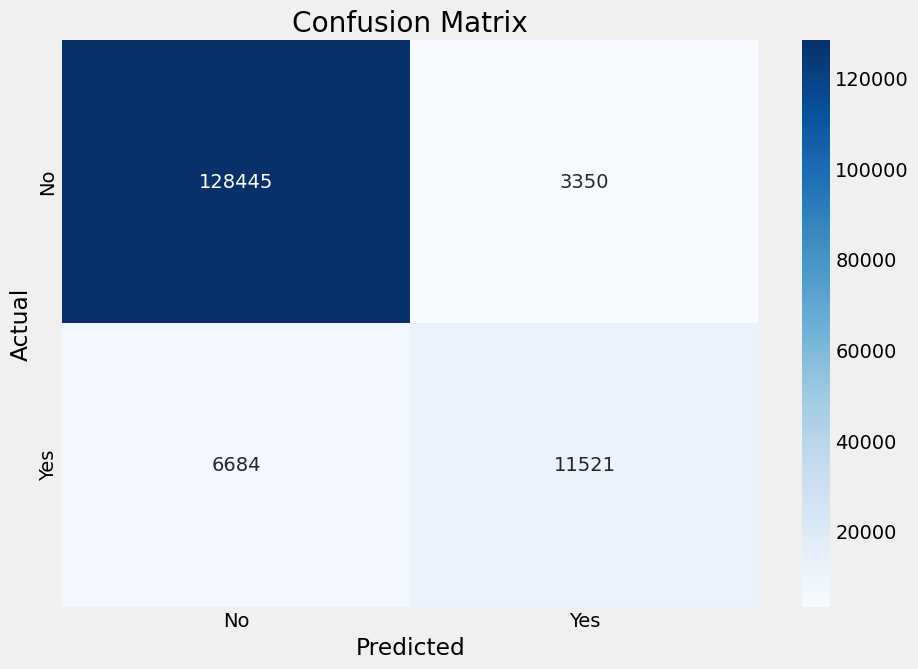

In [131]:
# Calculate confusion matrix using y_val and y_pred

# Determine y_val as the last column of y_val and convert to int
y_val = y_val_tensor.numpy().flatten().astype(int)
print("y_val shape:", y_val.shape)
print("y_val:", y_val)

# Determine y_pred as the predictions from the model on the validation set
predictions_val = sbs.predict(x_val_tensor)
y_classes = (predictions_val >= 0).astype(int)
y_pred = y_classes.flatten()
print("y_pred shape:", y_pred.shape)
print("y_pred:", y_pred)

# Determine probabilities
probabilities_val = sigmoid(predictions_val)

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### True and False Positives and Negatives

In [132]:
def split_cm(cm):
    # Actual negatives go in the top row, 
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row, 
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]

    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    
    return tn, fp, fn, tp

### Metrics

### True and False Positive Rates

$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

In [133]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    # Print TPR and FPR as percentages
    print(f"TPR: {tpr * 100:.2f}%, FPR: {fpr * 100:.2f}%")

    return tpr, fpr

In [134]:
tpr_fpr(cm)

TN: 128445, FP: 3350, FN: 6684, TP: 11521
TPR: 63.28%, FPR: 2.54%


(np.float64(0.6328481186487229), np.float64(0.025418263211806215))

### Precision and Recall

$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

In [135]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    # Print precision and recall as percentages
    print(f"Precision: {precision * 100:.2f}%, Recall: {recall * 100:.2f}%")

    return precision, recall

In [136]:
precision_recall(cm)

TN: 128445, FP: 3350, FN: 6684, TP: 11521
Precision: 77.47%, Recall: 63.28%


(np.float64(0.7747293389819111), np.float64(0.6328481186487229))

### Accuracy

$$
\Large \text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}
$$

In [137]:
# Calculate accuracy
def accuracy(cm):
    tn, fp, fn, tp = split_cm(cm)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

accuracy(cm)

TN: 128445, FP: 3350, FN: 6684, TP: 11521
Accuracy: 93.31%


np.float64(0.9331066666666666)

### ROC and Precision-Recall Curves

In [ ]:
# Calculate ROC and Precision-Recall Curves
fpr, tpr, thresholds = roc_curve(y_val, probabilities_val)
precision, recall, _ = precision_recall_curve(y_val, probabilities_val)

### Comparing Models

In [144]:
# Area under the ROC and Precision-Recall curves of our model
auroc = auc(fpr, tpr)
aupr = auc(recall, precision)
# Print area under the curves as percentages
print(f"AUROC: {auroc * 100:.3f}%")
print(f"AUPR: {aupr * 100:.3f}%")

AUROC: 96.348%
AUPR: 78.851%
